# Trajectory Recommendation using RankSVM and Factorised Markov Chain

<a id='toc'></a>

[Table of Contents](#toc)
1. [Preprocess Dataset](#1.-Preprocess-Dataset)
  1. [Load Data](#1.1-Load-Data)
  1. [Utility Functions](#1.2-Utility-Functions)
1. [POI Ranking](#2.-POI-Ranking)
  1. [POI Features for Ranking](#2.1-POI-Features-for-Ranking)
  1. [Training DataFrame](#2.2-Training-DataFrame)
  1. [Test DataFrame](#2.3-Test-DataFrame)
  1. [Ranking POIs using rankSVM](#2.4-Ranking-POIs-using-rankSVM)
1. [Factorised Transition Probabilities between POIs](#3.-Factorised-Transition-Probabilities-between-POIs)
  1. [POI Features for Factorisation](#3.1-POI-Features-for-Factorisation)
  1. [Transition Matrix between POI Cateogries](#3.2-Transition-Matrix-between-POI-Cateogries)
  1. [Transition Matrix between POI Popularity Classes](#3.3-Transition-Matrix-between-POI-Popularity-Classes)
  1. [Transition Matrix between the Number of POI Visit Classes](#3.4-Transition-Matrix-between-the-Number-of-POI-Visit-Classes)
  1. [Transition Matrix between POI Average Visit Duration Classes](#3.5-Transition-Matrix-between-POI-Average-Visit-Duration-Classes)
  1. [Transition Matrix between POI Neighborhood Classes](#3.6-Transition-Matrix-between-POI-Neighborhood-Classes)
  1. [Visualise Transition Matrices for Individual Features](#3.7-Visualise-Transition-Matrices-for-Individual-Features)
  1. [Transition Matrix between POIs](#3.8-Transition-Matrix-between-POIs)
1. [Trajectory Recommendation - Leave-one-out Evaluation](#4.-Trajectory-Recommendation---Leave-one-out-Evaluation)
1. [Random Guessing](#5.-Random-Guessing)

**Usage: **
1. Install [RankSVM implementation](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/#large_scale_ranksvm) and assign the directory/path to variable `ranksvm_dir`.
1. Install Python modules imported by this notebook.
1. Please change the value of index variable `dat_ix` (feasible values: `0, 1, 2, 3, 4`) to run this notebook on different dataset, results (.pkl file) will be saved in directory indicated by variable `data_dir`. 

# 1. Preprocess Dataset

In [99]:
%matplotlib inline

import os, sys, time, pickle, tempfile
import math, random, itertools
import pandas as pd
import numpy as np
from scipy.linalg import kron
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
import sklearn
from joblib import Parallel, delayed
import joblib
import cython
import pulp
import sys

In [104]:
print(sys.version)
print(pd.__version__)
print(np.__version__)
print(scipy.__version__)
print(sklearn.__version__)
print(joblib.__version__)
print(cython.__version__)
print(pulp.__version__)
print(sns.__version__)

3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
1.1.5
1.19.4
1.4.1
0.22.1
0.14.1
0.29.15
2.4
0.10.0


In [2]:
random.seed(1234567890)
np.random.seed(1234567890)
LOG_SMALL = -10
LOG_ZERO = -1000
# ranksvm_dir = '$HOME/work/ranksvm'  # directory that contains rankSVM binaries: train, predict, svm-scale
ranksvm_dir = r"C:\Users\Marek\Skola\TU\exp_design_temp\libsvm-ranksvm-3.24\windows"  # directory that contains rankSVM binaries: train, predict, svm-scale

In [3]:
data_dir = 'data'
dat_suffix = ['Osak', 'Glas', 'Edin', 'Toro', 'Melb']

In [4]:
dat_ix = 0

Hyperparameters.

In [5]:
ALPHA_SET = [0.1, 0.3, 0.5, 0.7, 0.9]  # trade-off parameters

In [6]:
BIN_CLUSTER = 5  # discritization parameter

In [7]:
RANKSVM_COST = 10  # RankSVM regularisation constant
N_JOBS = 2         # number of parallel jobs
USE_GUROBI = False # whether to use GUROBI as ILP solver

Method switches.

In [8]:
run_rank = True
run_tran = True
run_comb = True
run_rand = True

Generate results filenames.

In [9]:
def gen_fname(dat_ix):
    assert(0 <= dat_ix < len(dat_suffix))
    
    suffix = dat_suffix[dat_ix] + '.pkl'
    
    frank = os.path.join(data_dir, 'rank-' + suffix)
    ftran = os.path.join(data_dir, 'tran-' + suffix)
    fcomb = os.path.join(data_dir, 'comb-' + suffix)
    frand = os.path.join(data_dir, 'rand-' + suffix)
    return frank, ftran, fcomb, frand

In [10]:
frecdict_rank, frecdict_tran, frecdict_comb, frecdict_rand = gen_fname(dat_ix)
print(frecdict_rank)
print(frecdict_tran)
print(frecdict_comb)
print(frecdict_rand)

data\rank-Osak.pkl
data\tran-Osak.pkl
data\comb-Osak.pkl
data\rand-Osak.pkl


## 1.1 Load Data

In [11]:
fpoi = os.path.join(data_dir, 'poi-' + dat_suffix[dat_ix] + '.csv')

In [12]:
poi_all = pd.read_csv(fpoi)
poi_all.set_index('poiID', inplace=True)
poi_all.head()

,poiCat,poiLon,poiLat
poiID,,,
1,Amusement,135.428938,34.654792
2,Amusement,135.430627,34.656145
3,Amusement,135.508558,34.652423
4,Amusement,135.433627,34.664758
5,Amusement,135.499894,34.703680


In [13]:
ftraj = os.path.join(data_dir, 'traj-' + dat_suffix[dat_ix] + '.csv')

In [14]:
traj_all = pd.read_csv(ftraj)
traj_all.head()

,userID,trajID,poiID,startTime,endTime,#photo,trajLen,poiDuration
0,10297518@N00,1,20,1277719324,1277720832,6,1,1508
1,10307040@N08,2,6,1382608644,1382608644,1,4,0
2,10307040@N08,2,8,1382607812,1382607812,1,4,0
3,10307040@N08,2,21,1382607761,1382607774,2,4,13
4,10307040@N08,2,22,1382607879,1382608628,9,4,749


In [15]:
num_user = traj_all['userID'].unique().shape[0]
num_poi = traj_all['poiID'].unique().shape[0]
num_traj = traj_all['trajID'].unique().shape[0]
pd.DataFrame({'#user': num_user, '#poi': num_poi, '#traj': num_traj, '#traj/user': num_traj/num_user}, \
             index=[str(dat_suffix[dat_ix])])

,#user,#poi,#traj,#traj/user
Osak,450,27,1115,2.477778


Distribution of the number of POIs in trajectories.

Text(0, 0.5, '#Trajectories')

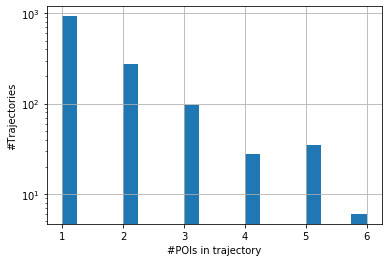

In [16]:
ax = traj_all['trajLen'].hist(bins=20)
ax.set_yscale('log')
ax.set_xlabel('#POIs in trajectory'); ax.set_ylabel('#Trajectories')

Distribution of POI visit duration.

Text(0, 0.5, '#POI visits')

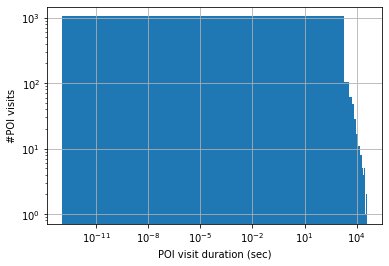

In [17]:
ax = traj_all['poiDuration'].hist(bins=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('POI visit duration (sec)'); ax.set_ylabel('#POI visits')

## 1.2 Utility Functions

Print computing progress.

In [18]:
def print_progress(cnt, total):
    """Display a progress bar"""
    assert(cnt > 0 and total > 0 and cnt <= total)
    length = 80
    ratio = cnt / total
    n = int(length * ratio)
    sys.stdout.write('\r[%-80s] %d%%' % ('-'*n, int(ratio*100)))
    sys.stdout.flush()

Extract trajectory, i.e., a list of POIs.

In [19]:
def extract_traj(tid, traj_all):
    traj = traj_all[traj_all['trajID'] == tid].copy()
    traj.sort_values(by=['startTime'], ascending=True, inplace=True)
    return traj['poiID'].tolist()

Compute POI properties, e.g., popularity, total number of visit, average visit duration.

In [20]:
def calc_poi_info(trajid_list, traj_all, poi_all):
    assert(len(trajid_list) > 0)
    poi_info = traj_all[traj_all['trajID'] == trajid_list[0]][['poiID', 'poiDuration']].copy() 
    for i in range(1, len(trajid_list)):
        traj = traj_all[traj_all['trajID'] == trajid_list[i]][['poiID', 'poiDuration']]
        poi_info = poi_info.append(traj, ignore_index=True)
    
    poi_info = poi_info.groupby('poiID').agg([np.mean, np.size])
    poi_info.columns = poi_info.columns.droplevel()
    poi_info.reset_index(inplace=True)
    poi_info.rename(columns={'mean':'avgDuration', 'size':'nVisit'}, inplace=True)
    poi_info.set_index('poiID', inplace=True) 
    poi_info['poiCat'] = poi_all.loc[poi_info.index, 'poiCat']
    poi_info['poiLon'] = poi_all.loc[poi_info.index, 'poiLon']
    poi_info['poiLat'] = poi_all.loc[poi_info.index, 'poiLat']
    
    # POI popularity: the number of distinct users that visited the POI
    pop_df = traj_all[traj_all['trajID'].isin(trajid_list)][['poiID', 'userID']].copy()
    pop_df = pop_df.groupby('poiID').agg(pd.Series.nunique)
    pop_df.rename(columns={'userID':'nunique'}, inplace=True)
    poi_info['popularity'] = pop_df.loc[poi_info.index, 'nunique']
    
    return poi_info.copy()

Compute the F1 score for recommended trajectory.

In [21]:
def calc_F1(traj_act, traj_rec, noloop=False):
    '''Compute recall, precision and F1 for recommended trajectories'''
    assert(isinstance(noloop, bool))
    assert(len(traj_act) > 0)
    assert(len(traj_rec) > 0)
    
    if noloop == True:
        intersize = len(set(traj_act) & set(traj_rec))
    else:
        match_tags = np.zeros(len(traj_act), dtype=np.bool)
        for poi in traj_rec:
            for j in range(len(traj_act)):
                if match_tags[j] == False and poi == traj_act[j]:
                    match_tags[j] = True
                    break
        intersize = np.nonzero(match_tags)[0].shape[0]
        
    recall = intersize / len(traj_act)
    precision = intersize / len(traj_rec)
    F1 = 2 * precision * recall / (precision + recall)
    return F1

Compute the pairs-F1 score for recommended trajectory.

In [22]:
%load_ext Cython

In [23]:
%%cython
import numpy as np
cimport numpy as np

cpdef float calc_pairsF1(y, y_hat):
    assert(len(y) > 0)
    assert(len(y) == len(set(y))) # no loops in y
    cdef int n, nr, n0, n0r, nc, poi1, poi2, i, j
    n = len(y)
    nr = len(y_hat)
    n0 = n*(n-1) // 2
    n0r = nr*(nr-1) // 2
    
    # y determines the correct visiting order
    order_dict = dict()
    for i in range(n):
        order_dict[y[i]] = i
        
    nc = 0
    for i in range(nr):
        poi1 = y_hat[i]
        for j in range(i+1, nr):
            poi2 = y_hat[j]
            if poi1 in order_dict and poi2 in order_dict and poi1 != poi2:
                if order_dict[poi1] < order_dict[poi2]: nc += 1

    cdef float precision, recall, F1
    precision = (1.0 * nc) / (1.0 * n0r)
    recall = (1.0 * nc) / (1.0 * n0)
    if nc == 0:
        F1 = 0
    else:
        F1 = 2. * precision * recall / (precision + recall)
    return F1

Compute distance between two POIs using [Haversine formula](http://en.wikipedia.org/wiki/Great-circle_distance).

In [24]:
def calc_dist_vec(longitudes1, latitudes1, longitudes2, latitudes2):
    """Calculate the distance (unit: km) between two places on earth, vectorised"""
    # convert degrees to radians
    lng1 = np.radians(longitudes1)
    lat1 = np.radians(latitudes1)
    lng2 = np.radians(longitudes2)
    lat2 = np.radians(latitudes2)
    radius = 6371.0088 # mean earth radius, en.wikipedia.org/wiki/Earth_radius#Mean_radius

    # The haversine formula, en.wikipedia.org/wiki/Great-circle_distance
    dlng = np.fabs(lng1 - lng2)
    dlat = np.fabs(lat1 - lat2)
    dist =  2 * radius * np.arcsin( np.sqrt( 
                (np.sin(0.5*dlat))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(0.5*dlng))**2 ))
    return dist

Distance between POIs.

In [25]:
POI_DISTMAT = pd.DataFrame(data=np.zeros((poi_all.shape[0], poi_all.shape[0]), dtype=np.float), \
                           index=poi_all.index, columns=poi_all.index)

In [26]:
for ix in poi_all.index:
    POI_DISTMAT.loc[ix] = calc_dist_vec(poi_all.loc[ix, 'poiLon'], \
                                        poi_all.loc[ix, 'poiLat'], \
                                        poi_all['poiLon'], \
                                        poi_all['poiLat'])

In [27]:
trajid_set_all = sorted(traj_all['trajID'].unique().tolist())

In [28]:
poi_info_all = calc_poi_info(trajid_set_all, traj_all, poi_all)

Dictionary maps every trajectory ID to the actual trajectory.

In [29]:
traj_dict = dict()

In [30]:
for trajid in trajid_set_all:
    traj = extract_traj(trajid, traj_all)
    assert(trajid not in traj_dict)
    traj_dict[trajid] = traj

Define a *query* (in IR terminology) using tuple (start POI, end POI, #POI) ~~user ID.~~

In [31]:
QUERY_ID_DICT = dict()  # (start, end, length) --> qid

In [32]:
keys = [(traj_dict[x][0], traj_dict[x][-1], len(traj_dict[x])) \
        for x in sorted(traj_dict.keys()) if len(traj_dict[x]) > 2]
cnt = 0
for key in keys:
    if key not in QUERY_ID_DICT:   # (start, end, length) --> qid
        QUERY_ID_DICT[key] = cnt
        cnt += 1

In [33]:
print('#traj in total:', len(trajid_set_all))
print('#traj (length > 2):', traj_all[traj_all['trajLen'] > 2]['trajID'].unique().shape[0])
print('#query tuple:', len(QUERY_ID_DICT))

#traj in total: 1115
#traj (length > 2): 47
#query tuple: 43


### Validation Set for Tuning $\alpha$

Split dataset (length $\ge 3$) into two (roughly) equal parts, use part 1 to tune alpha, then make prediction (leave-one-out CV) on part 2 using the tuned alpha, and vice verse. Compute the mean and std for all predictions.

NOTE: All short trajectories (length $\le 2$) are always included to compute POI features.

The whole set of trajectory ID (length $\ge 3$).

In [34]:
WHOLE_SET = traj_all[traj_all['trajLen'] > 2]['trajID'].unique()

Split the whole set randomly into two (roughly) equal parts.

In [35]:
WHOLE_SET = np.random.permutation(WHOLE_SET)
splitix = int(len(WHOLE_SET)*0.5)
PART1 = WHOLE_SET[:splitix]
PART2 = WHOLE_SET[splitix:]

# 2. POI Ranking

## 2.1 POI Features for Ranking

POI Features used for ranking, given query (`startPOI`, `endPOI`, `nPOI`):
1. `category`: one-hot encoding of POI category, encode `True` as `1` and `False` as `-1`
1. `neighbourhood`: one-hot encoding of POI cluster, encode `True` as `1` and `False` as `-1`
1. `popularity`: log of POI popularity, i.e., the number of distinct users that visited the POI
1. `nVisit`: log of the total number of visit by all users
1. `avgDuration`: log of average POI visit duration
1. `trajLen`: trajectory length, i.e., the number of POIs `nPOI` in trajectory, copy from query
1. `sameCatStart`: 1 if POI category is the same as that of `startPOI`, -1 otherwise
1. `sameCatEnd`: 1 if POI category is the same as that of `endPOI`, -1 otherwise
1. `distStart`: distance (haversine formula) from `startPOI`
1. `distEnd`: distance from `endPOI`
1. `diffPopStart`: difference in POI popularity from `startPOI` (NO LOG as it could be negative)
1. `diffPopEnd`: difference in POI popularity from `endPOI`
1. `diffNVisitStart`: difference in the total number of visit from `startPOI`
1. `diffNVisitEnd`: difference in the total number of visit from `endPOI`
1. `diffDurationStart`: difference in average POI visit duration from the actual duration spent at `startPOI`
1. `diffDurationEnd`: difference in average POI visit duration from the actual duration spent at `endPOI`
1. `sameNeighbourhoodStart`: 1 if POI resides in the same cluster as that of `startPOI`, -1 otherwise
1. `sameNeighbourhoodEnd`: 1 if POI resides in the same cluster as that of `endPOI`, -1 otherwise

In [36]:
DF_COLUMNS = ['poiID', 'label', 'queryID', 'category', 'neighbourhood', 'popularity', 'nVisit', 'avgDuration', \
              'trajLen', 'sameCatStart', 'sameCatEnd', 'distStart', 'distEnd', 'diffPopStart', 'diffPopEnd', \
              'diffNVisitStart', 'diffNVisitEnd', 'diffDurationStart', 'diffDurationEnd', \
              'sameNeighbourhoodStart', 'sameNeighbourhoodEnd']

## 2.2 Training DataFrame

Training data are generated as follows:
1. each input tuple $(\text{startPOI}, \text{endPOI}, \text{#POI})$ form a `query` (in IR terminology).
1. the label of a specific POI is the number of presence of that POI in the set of trajectories grouped by a specific `query`, excluding the presence as $\text{startPOI}$ or $\text{endPOI}$. (the label of all absence POIs w.r.t. that `query` got a label `0`)

The dimension of training data matrix is `#(qid, poi)` by `#feature`.

In [37]:
def gen_train_subdf(poi_id, query_id_set, poi_info, poi_clusters, cats, clusters, query_id_rdict):
    assert(isinstance(cats, list))
    assert(isinstance(clusters, list))
    
    columns = DF_COLUMNS
    poi_distmat = POI_DISTMAT
    df_ = pd.DataFrame(index=np.arange(len(query_id_set)), columns=columns)
    
    pop, nvisit = poi_info.loc[poi_id, 'popularity'], poi_info.loc[poi_id, 'nVisit']
    cat, cluster = poi_info.loc[poi_id, 'poiCat'], poi_clusters.loc[poi_id, 'clusterID'] 
    duration = poi_info.loc[poi_id, 'avgDuration']
    
    for j in range(len(query_id_set)):
        qid = query_id_set[j]
        assert(qid in query_id_rdict) # qid --> (start, end, length)
        (p0, pN, trajLen) = query_id_rdict[qid]
        idx = df_.index[j]
        df_.loc[idx, 'poiID'] = poi_id
        df_.loc[idx, 'queryID'] = qid
        df_.at[idx, 'category'] = tuple((cat == np.array(cats)).astype(np.int) * 2 - 1)
        df_.at[idx, 'neighbourhood'] = tuple((cluster == np.array(clusters)).astype(np.int) * 2 - 1)
        df_.loc[idx, 'popularity'] = LOG_SMALL if pop < 1 else np.log10(pop)
        df_.loc[idx, 'nVisit'] = LOG_SMALL if nvisit < 1 else np.log10(nvisit)
        df_.loc[idx, 'avgDuration'] = LOG_SMALL if duration < 1 else np.log10(duration)
        df_.loc[idx, 'trajLen'] = trajLen
        df_.loc[idx, 'sameCatStart'] = 1 if cat == poi_info.loc[p0, 'poiCat'] else -1
        df_.loc[idx, 'sameCatEnd']   = 1 if cat == poi_info.loc[pN, 'poiCat'] else -1
        df_.loc[idx, 'distStart'] = poi_distmat.loc[poi_id, p0]
        df_.loc[idx, 'distEnd']   = poi_distmat.loc[poi_id, pN]
        df_.loc[idx, 'diffPopStart'] = pop - poi_info.loc[p0, 'popularity']
        df_.loc[idx, 'diffPopEnd']   = pop - poi_info.loc[pN, 'popularity']
        df_.loc[idx, 'diffNVisitStart'] = nvisit - poi_info.loc[p0, 'nVisit']
        df_.loc[idx, 'diffNVisitEnd']   = nvisit - poi_info.loc[pN, 'nVisit']
        df_.loc[idx, 'diffDurationStart'] = duration - poi_info.loc[p0, 'avgDuration']
        df_.loc[idx, 'diffDurationEnd']   = duration - poi_info.loc[pN, 'avgDuration']
        df_.loc[idx, 'sameNeighbourhoodStart'] = 1 if cluster == poi_clusters.loc[p0, 'clusterID'] else -1
        df_.loc[idx, 'sameNeighbourhoodEnd']   = 1 if cluster == poi_clusters.loc[pN, 'clusterID'] else -1
        
    return df_

In [38]:
def gen_train_df(trajid_list, traj_dict, poi_info, poi_clusters, cats, clusters, n_jobs=-1):    
    columns = DF_COLUMNS
    poi_distmat = POI_DISTMAT
    query_id_dict = QUERY_ID_DICT
    train_trajs = [traj_dict[x] for x in trajid_list if len(traj_dict[x]) > 2]
    
    qid_set = sorted(set([query_id_dict[(t[0], t[-1], len(t))] for t in train_trajs]))
    poi_set = set()
    for tr in train_trajs:
        poi_set = poi_set | set(tr)
    
    query_id_rdict = dict()
    for k, v in query_id_dict.items(): 
        query_id_rdict[v] = k  # qid --> (start, end, length)
    
    train_df_list = Parallel(n_jobs=n_jobs)\
                            (delayed(gen_train_subdf)(poi, qid_set, poi_info, poi_clusters,cats,clusters,query_id_rdict) 
                             for poi in poi_set)
                        
    assert(len(train_df_list) > 0)
    df_ = train_df_list[0]
    for j in range(1, len(train_df_list)):
        df_ = df_.append(train_df_list[j], ignore_index=True)            
        
    # set label
    df_.set_index(['queryID', 'poiID'], inplace=True)
    df_['label'] = 0
    for t in train_trajs:
        qid = query_id_dict[(t[0], t[-1], len(t))]
        for poi in t[1:-1]:  # do NOT count if the POI is startPOI/endPOI
            df_.loc[(qid, poi), 'label'] += 1

    df_.reset_index(inplace=True)
    return df_

## 2.3 Test DataFrame

Test data are generated the same way as training data, except that the labels of testing data (unknown) could be arbitrary values as suggested in [libsvm FAQ](http://www.csie.ntu.edu.tw/~cjlin/libsvm/faq.html#f431).
The reported accuracy (by `svm-predict` command) is meaningless as it is calculated based on these labels.

The dimension of training data matrix is `#poi` by `#feature` with one specific `query`, i.e. tuple $(\text{startPOI}, \text{endPOI}, \text{#POI})$.

In [39]:
def gen_test_df(startPOI, endPOI, nPOI, poi_info, poi_clusters, cats, clusters):
    assert(isinstance(cats, list))
    assert(isinstance(clusters, list))
    
    columns = DF_COLUMNS
    poi_distmat = POI_DISTMAT
    query_id_dict = QUERY_ID_DICT
    key = (p0, pN, trajLen) = (startPOI, endPOI, nPOI)
    assert(key in query_id_dict)
    assert(p0 in poi_info.index)
    assert(pN in poi_info.index)
    
    df_ = pd.DataFrame(index=np.arange(poi_info.shape[0]), columns=columns)
    poi_list = sorted(poi_info.index)
    
    qid = query_id_dict[key]
    df_['queryID'] = qid
    df_['label'] = np.random.rand(df_.shape[0]) # label for test data is arbitrary according to libsvm FAQ

    for i in range(df_.index.shape[0]):
        poi = poi_list[i]
        lon, lat = poi_info.loc[poi, 'poiLon'], poi_info.loc[poi, 'poiLat']
        pop, nvisit = poi_info.loc[poi, 'popularity'], poi_info.loc[poi, 'nVisit']
        cat, cluster = poi_info.loc[poi, 'poiCat'], poi_clusters.loc[poi, 'clusterID']
        duration = poi_info.loc[poi, 'avgDuration']
        idx = df_.index[i]
        df_.loc[idx, 'poiID'] = poi
        df_.at [idx, 'category'] = tuple((cat == np.array(cats)).astype(np.int) * 2 - 1)
        df_.at [idx, 'neighbourhood'] = tuple((cluster == np.array(clusters)).astype(np.int) * 2 - 1)
        df_.loc[idx, 'popularity'] = LOG_SMALL if pop < 1 else np.log10(pop)
        df_.loc[idx, 'nVisit'] = LOG_SMALL if nvisit < 1 else np.log10(nvisit)
        df_.loc[idx, 'avgDuration'] = LOG_SMALL if duration < 1 else np.log10(duration)
        df_.loc[idx, 'trajLen'] = trajLen
        df_.loc[idx, 'sameCatStart'] = 1 if cat == poi_all.loc[p0, 'poiCat'] else -1
        df_.loc[idx, 'sameCatEnd']   = 1 if cat == poi_all.loc[pN, 'poiCat'] else -1
        df_.loc[idx, 'distStart'] = poi_distmat.loc[poi, p0]
        df_.loc[idx, 'distEnd']   = poi_distmat.loc[poi, pN]
        df_.loc[idx, 'diffPopStart'] = pop - poi_info.loc[p0, 'popularity']
        df_.loc[idx, 'diffPopEnd']   = pop - poi_info.loc[pN, 'popularity']
        df_.loc[idx, 'diffNVisitStart'] = nvisit - poi_info.loc[p0, 'nVisit']
        df_.loc[idx, 'diffNVisitEnd']   = nvisit - poi_info.loc[pN, 'nVisit']
        df_.loc[idx, 'diffDurationStart'] = duration - poi_info.loc[p0, 'avgDuration']
        df_.loc[idx, 'diffDurationEnd']   = duration - poi_info.loc[pN, 'avgDuration']
        df_.loc[idx, 'sameNeighbourhoodStart'] = 1 if cluster == poi_clusters.loc[p0, 'clusterID'] else -1
        df_.loc[idx, 'sameNeighbourhoodEnd']   = 1 if cluster == poi_clusters.loc[pN, 'clusterID'] else -1
        
    return df_

Generate a string for a training/test data frame.

In [40]:
def gen_data_str(df_, df_columns=DF_COLUMNS):
    for col in df_columns:
        assert(col in df_.columns)
        
    lines = []
    for idx in df_.index:
        slist = [str(df_.loc[idx, 'label'])]
        slist.append(' qid:')
        slist.append(str(int(df_.loc[idx, 'queryID'])))
        fid = 1
        for j in range(3, len(df_columns)):
            values_ = df_.at[idx, df_columns[j]]
            values_ = values_ if isinstance(values_, tuple) else [values_]
            for v in values_:
                slist.append(' ')
                slist.append(str(fid)); fid += 1
                slist.append(':')
                slist.append(str(v))
        slist.append('\n')
        lines.append(''.join(slist))
    return ''.join(lines)

## 2.4 Ranking POIs using rankSVM

Here the [rankSVM implementation](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/#large_scale_ranksvm) could be [liblinear-ranksvm](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/ranksvm/liblinear-ranksvm-2.1.zip) or [libsvm-ranksvm](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/ranksvm/libsvm-ranksvm-3.20.zip), please read `README.ranksvm` in the zip file for installation instructions.

Use [softmax function](https://en.wikipedia.org/wiki/Softmax_function) to convert ranking scores to a probability distribution.

In [41]:
def softmax(x):
    x1 = x.copy()
    x1 -= np.max(x1)  # numerically more stable, REF: http://cs231n.github.io/linear-classify/#softmax
    expx = np.exp(x1)
    return expx / np.sum(expx, axis=0) # column-wise sum

Below is a python wrapper of the `svm-train` or `train` and `svm-predict` or `predict` commands of rankSVM with ranking probabilities $P(p_i \lvert (p_s, p_e, len))$ computed using [softmax function](https://en.wikipedia.org/wiki/Softmax_function).

In [42]:
# python wrapper of rankSVM
class RankSVM:
    def __init__(self, bin_dir, useLinear=True, debug=False):
        # deal with environmental variables in path
#         dir_ = !echo $bin_dir  
#         assert(os.path.exists(dir_[0]))
#         self.bin_dir = dir_[0]
        self.bin_dir = bin_dir

        
        self.bin_train = 'svm-train.exe'
        self.bin_predict = 'svm-predict.exe'
        if useLinear:
            self.bin_train = 'train'
            self.bin_predict = 'predict'
        
        assert(isinstance(debug, bool))
        self.debug = debug
        
        # create named tmp files for model and feature scaling parameters
        self.fmodel = None
        self.fscale = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fmodel = fd.name
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fscale = fd.name
        
        if self.debug:
            print('model file:', self.fmodel)
            print('feature scaling parameter file:', self.fscale)
    
    
    def __del__(self):
        # remove tmp files
        if self.debug == False:
            if self.fmodel is not None and os.path.exists(self.fmodel):
                os.unlink(self.fmodel)
            if self.fscale is not None and os.path.exists(self.fscale):
                os.unlink(self.fscale)

    
    def train(self, train_df, cost=1):
        # cost is parameter C in SVM
        # write train data to file
        ftrain = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain = fd.name
            datastr = gen_data_str(train_df)
            fd.write(datastr)
        
        # feature scaling
        ftrain_scaled = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain_scaled = fd.name
        result = !$self.bin_dir\\svm-scale.exe -s $self.fscale $ftrain > $ftrain_scaled
#         os.system(f"{self.bin_dir}\\svm-scale.exe -s {self.fscale} {ftrain} > {ftrain_scaled}")

        test = !echo $self.bin_dir
        
        
        if self.debug:
            print('cost:', cost)
            print('train data file:', ftrain)
            print('feature scaled train data file:', ftrain_scaled)
        
        # train rank svm and generate model file, if the model file exists, rewrite it
        result = !$self.bin_dir\\$self.bin_train -c $cost $ftrain_scaled $self.fmodel
        if self.debug:
            print('Training finished.')
            for i in range(len(result)): print(result[i])

        # remove train data file
        if self.debug == False:
            os.unlink(ftrain)
            os.unlink(ftrain_scaled)        

    
    def predict(self, test_df):
        # predict ranking scores for the given feature matrix
        if self.fmodel is None or not os.path.exists(self.fmodel):
            print('Model should be trained before prediction')
            return
        
        # write test data to file
        ftest = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftest = fd.name
            datastr = gen_data_str(test_df)
            fd.write(datastr)
                
        # feature scaling
        ftest_scaled = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            ftest_scaled = fd.name
        result = !$self.bin_dir\\svm-scale.exe -r $self.fscale $ftest > $ftest_scaled

        
        # generate prediction file
        fpredict = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            fpredict = fd.name
            
        if self.debug:
            print('test data file:', ftest)
            print('feature scaled test data file:', ftest_scaled)
            print('predict result file:', fpredict)
            
        # predict using trained model and write prediction to file
        result = !$self.bin_dir\\$self.bin_predict $ftest_scaled $self.fmodel $fpredict
        
        if self.debug:
            print('Predict result: %-30s  %s' % (result[0], result[1]))
        
        # generate prediction DataFrame from prediction file
  
        poi_rank_df = pd.read_csv(fpredict, header=None)
        poi_rank_df.rename(columns={0:'rank'}, inplace=True)
        poi_rank_df['poiID'] = test_df['poiID'].astype(np.int)
        poi_rank_df.set_index('poiID', inplace=True)
        poi_rank_df['probability'] = softmax(poi_rank_df['rank'])
        
        # remove test file and prediction file
        if self.debug == False:
            os.unlink(ftest)
            os.unlink(ftest_scaled)
            os.unlink(fpredict)

        return poi_rank_df

# 3. Factorised Transition Probabilities between POIs

Estimate a transition matrix for each feature of POI, transition probabilities between different POIs are obtrained by the Kronecker product of the individual transition matrix corresponding to each feature (with normalisation and a few constraints).

## 3.1 POI Features for Factorisation

POI features used to factorise transition matrix of Markov Chain with POI features (vector) as states:
- Category of POI
- Popularity of POI (discritize with uniform log-scale bins, #bins <=5 )
- The number of POI visits (discritize with uniform log-scale bins, #bins <=5 )
- The average visit duration of POI (discritise with uniform log-scale bins, #bins <= 5)
- The neighborhood relationship between POIs (clustering POI(lat, lon) using k-means, #clusters <= 5)

We count the number of transition first, then normalise each row while taking care of zero by adding each cell a number $k=1$.

In [43]:
def normalise_transmat(transmat_cnt):
    transmat = transmat_cnt.copy()
    assert(isinstance(transmat, pd.DataFrame))
    for row in range(transmat.index.shape[0]):
        rowsum = np.sum(transmat.iloc[row] + 1)
        assert(rowsum > 0)
        transmat.iloc[row] = (transmat.iloc[row] + 1) / rowsum
    return transmat

POIs in training set.

In [44]:
poi_train = sorted(poi_info_all.index)

## 3.2 Transition Matrix between POI Cateogries

In [45]:
poi_cats = poi_all.loc[poi_train, 'poiCat'].unique().tolist()
poi_cats.sort()
POI_CAT_LIST = poi_cats
POI_CAT_LIST

['Amusement', 'Entertainment', 'Historical', 'Park']

In [46]:
def gen_transmat_cat(trajid_list, traj_dict, poi_info, poi_cats=POI_CAT_LIST):
    transmat_cat_cnt = pd.DataFrame(data=np.zeros((len(poi_cats), len(poi_cats)), dtype=np.float), \
                                    columns=poi_cats, index=poi_cats)
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                cat1 = poi_info.loc[p1, 'poiCat']
                cat2 = poi_info.loc[p2, 'poiCat']
                transmat_cat_cnt.loc[cat1, cat2] += 1
    return normalise_transmat(transmat_cat_cnt)

In [47]:
gen_transmat_cat(trajid_set_all, traj_dict, poi_info_all)

,Amusement,Entertainment,Historical,Park
Amusement,0.576923,0.256410,0.012821,0.153846
Entertainment,0.243478,0.556522,0.052174,0.147826
Historical,0.166667,0.375000,0.125000,0.333333
Park,0.410714,0.392857,0.089286,0.107143


## 3.3 Transition Matrix between POI Popularity Classes

In [48]:
poi_pops = poi_info_all.loc[poi_train, 'popularity']

Discretize POI popularity with uniform log-scale bins.

In [49]:
expo_pop1 = np.log10(max(1, min(poi_pops)))
expo_pop2 = np.log10(max(poi_pops))
print(expo_pop1, expo_pop2)

0.0 2.1072099696478683


In [50]:
nbins_pop = BIN_CLUSTER
logbins_pop = np.logspace(np.floor(expo_pop1), np.ceil(expo_pop2), nbins_pop+1)
logbins_pop[0] = 0  # deal with underflow
if logbins_pop[-1] < poi_info_all['popularity'].max():
    logbins_pop[-1] = poi_info_all['popularity'].max() + 1
logbins_pop

array([   0.        ,    3.98107171,   15.84893192,   63.09573445,
        251.18864315, 1000.        ])

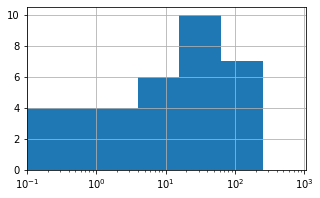

In [51]:
ax = pd.Series(poi_pops).hist(figsize=(5, 3), bins=logbins_pop)
ax.set_xlim(xmin=0.1)
ax.set_xscale('log')

In [52]:
def gen_transmat_pop(trajid_list, traj_dict, poi_info, logbins_pop=logbins_pop):
    nbins = len(logbins_pop) - 1
    transmat_pop_cnt = pd.DataFrame(data=np.zeros((nbins, nbins), dtype=np.float), \
                                    columns=np.arange(1, nbins+1), index=np.arange(1, nbins+1))
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                pop1 = poi_info.loc[p1, 'popularity']
                pop2 = poi_info.loc[p2, 'popularity']
                pc1, pc2 = np.digitize([pop1, pop2], logbins_pop)
                transmat_pop_cnt.loc[pc1, pc2] += 1
    return normalise_transmat(transmat_pop_cnt), logbins_pop

In [53]:
gen_transmat_pop(trajid_set_all, traj_dict, poi_info_all)[0]

,1,2,3,4,5
1,0.142857,0.142857,0.285714,0.285714,0.142857
2,0.080000,0.040000,0.480000,0.360000,0.040000
3,0.009901,0.069307,0.326733,0.584158,0.009901
4,0.020833,0.034722,0.354167,0.583333,0.006944
5,0.200000,0.200000,0.200000,0.200000,0.200000


## 3.4 Transition Matrix between the Number of POI Visit Classes

In [54]:
poi_visits = poi_info_all.loc[poi_train, 'nVisit']

Discretize the number of POI visit with uniform log-scale bins.

In [55]:
expo_visit1 = np.log10(max(1, min(poi_visits)))
expo_visit2 = np.log10(max(poi_visits))
print(expo_visit1, expo_visit2)

0.0 2.164352855784437


In [56]:
nbins_visit = BIN_CLUSTER
logbins_visit = np.logspace(np.floor(expo_visit1), np.ceil(expo_visit2), nbins_visit+1)
logbins_visit[0] = 0  # deal with underflow
if logbins_visit[-1] < poi_info_all['nVisit'].max():
    logbins_visit[-1] = poi_info_all['nVisit'].max() + 1
logbins_visit

array([   0.        ,    3.98107171,   15.84893192,   63.09573445,
        251.18864315, 1000.        ])

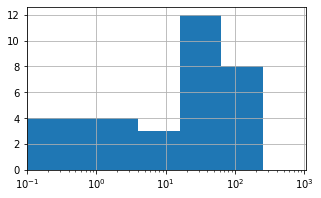

In [57]:
ax = pd.Series(poi_visits).hist(figsize=(5, 3), bins=logbins_visit)
ax.set_xlim(xmin=0.1)
ax.set_xscale('log')

In [58]:
def gen_transmat_visit(trajid_list, traj_dict, poi_info, logbins_visit=logbins_visit):
    nbins = len(logbins_visit) - 1
    transmat_visit_cnt = pd.DataFrame(data=np.zeros((nbins, nbins), dtype=np.float), \
                                      columns=np.arange(1, nbins+1), index=np.arange(1, nbins+1))
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                visit1 = poi_info.loc[p1, 'nVisit']
                visit2 = poi_info.loc[p2, 'nVisit']
                vc1, vc2 = np.digitize([visit1, visit2], logbins_visit)
                transmat_visit_cnt.loc[vc1, vc2] += 1
    return normalise_transmat(transmat_visit_cnt), logbins_visit

In [59]:
gen_transmat_visit(trajid_set_all, traj_dict, poi_info_all)[0]

,1,2,3,4,5
1,0.142857,0.142857,0.142857,0.428571,0.142857
2,0.111111,0.111111,0.333333,0.333333,0.111111
3,0.021739,0.021739,0.250000,0.695652,0.010870
4,0.017751,0.017751,0.325444,0.633136,0.005917
5,0.200000,0.200000,0.200000,0.200000,0.200000


## 3.5 Transition Matrix between POI Average Visit Duration Classes

In [60]:
poi_durations = poi_info_all.loc[poi_train, 'avgDuration']

In [61]:
expo_duration1 = np.log10(max(1, min(poi_durations)))
expo_duration2 = np.log10(max(poi_durations))
print(expo_duration1, expo_duration2)

0.0 3.915221701008328


In [62]:
nbins_duration = BIN_CLUSTER
logbins_duration = np.logspace(np.floor(expo_duration1), np.ceil(expo_duration2), nbins_duration+1)
logbins_duration[0] = 0  # deal with underflow
logbins_duration[-1] = np.power(10, expo_duration2+2)
logbins_duration

array([0.00000000e+00, 6.30957344e+00, 3.98107171e+01, 2.51188643e+02,
       1.58489319e+03, 8.22662500e+05])

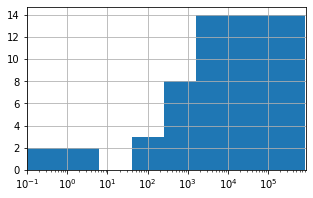

In [63]:
ax = pd.Series(poi_durations).hist(figsize=(5, 3), bins=logbins_duration)
ax.set_xlim(xmin=0.1)
ax.set_xscale('log')

In [64]:
def gen_transmat_duration(trajid_list, traj_dict, poi_info, logbins_duration=logbins_duration):
    nbins = len(logbins_duration) - 1
    transmat_duration_cnt = pd.DataFrame(data=np.zeros((nbins, nbins), dtype=np.float), \
                                         columns=np.arange(1, nbins+1), index=np.arange(1, nbins+1))
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                d1 = poi_info.loc[p1, 'avgDuration']
                d2 = poi_info.loc[p2, 'avgDuration']
                dc1, dc2 = np.digitize([d1, d2], logbins_duration)
                transmat_duration_cnt.loc[dc1, dc2] += 1
    return normalise_transmat(transmat_duration_cnt), logbins_duration

In [65]:
gen_transmat_duration(trajid_set_all, traj_dict, poi_info_all)[0]

,1,2,3,4,5
1,0.166667,0.166667,0.166667,0.166667,0.333333
2,0.200000,0.200000,0.200000,0.200000,0.200000
3,0.166667,0.166667,0.166667,0.166667,0.333333
4,0.014085,0.014085,0.014085,0.239437,0.718310
5,0.010309,0.005155,0.020619,0.231959,0.731959


## 3.6 Transition Matrix between POI Neighborhood Classes

KMeans in scikit-learn seems unable to use custom distance metric and no implementation of [Haversine formula](http://en.wikipedia.org/wiki/Great-circle_distance), use Euclidean distance to approximate.

In [66]:
X = poi_all.loc[poi_train, ['poiLon', 'poiLat']]
nclusters = BIN_CLUSTER

In [67]:
kmeans = KMeans(n_clusters=nclusters, random_state=987654321)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=987654321, tol=0.0001, verbose=0)

In [68]:
clusters = kmeans.predict(X)
POI_CLUSTER_LIST = sorted(np.unique(clusters))
POI_CLUSTERS = pd.DataFrame(data=clusters, index=poi_train)
POI_CLUSTERS.index.name = 'poiID'
POI_CLUSTERS.rename(columns={0:'clusterID'}, inplace=True)
POI_CLUSTERS['clusterID'] = POI_CLUSTERS['clusterID'].astype(np.int)

Scatter plot of POI coordinates with clustering results.

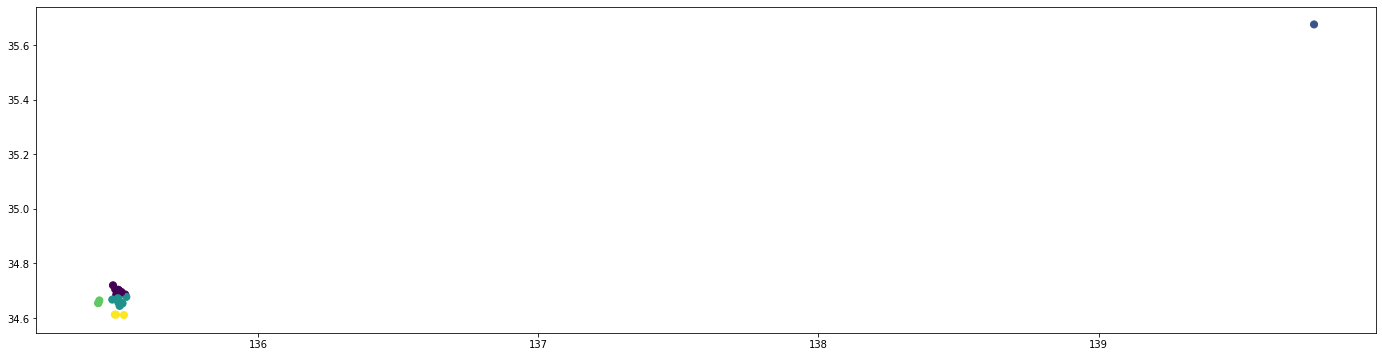

In [69]:
diff = poi_all.loc[poi_train, ['poiLon', 'poiLat']].max() - poi_all.loc[poi_train, ['poiLon', 'poiLat']].min()
ratio = diff['poiLon'] / diff['poiLat']
height = 6; width = int(round(ratio)*height)
plt.figure(figsize=[width, height])
plt.scatter(poi_all.loc[poi_train, 'poiLon'], poi_all.loc[poi_train, 'poiLat'], c=clusters, s=50)

In [70]:
def gen_transmat_neighbor(trajid_list, traj_dict, poi_info, poi_clusters=POI_CLUSTERS):
    nclusters = len(poi_clusters['clusterID'].unique())
    transmat_neighbor_cnt = pd.DataFrame(data=np.zeros((nclusters, nclusters), dtype=np.float), \
                                         columns=np.arange(nclusters), index=np.arange(nclusters))
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                c1 = poi_clusters.loc[p1, 'clusterID']
                c2 = poi_clusters.loc[p2, 'clusterID']
                transmat_neighbor_cnt.loc[c1, c2] += 1
    return normalise_transmat(transmat_neighbor_cnt), poi_clusters

In [71]:
gen_transmat_neighbor(trajid_set_all, traj_dict, poi_info_all)[0]

,0,1,2,3,4
0,0.440476,0.011905,0.404762,0.119048,0.023810
1,0.200000,0.200000,0.200000,0.200000,0.200000
2,0.290076,0.007634,0.664122,0.015267,0.022901
3,0.226415,0.018868,0.094340,0.641509,0.018868
4,0.222222,0.111111,0.333333,0.222222,0.111111


## 3.8 Transition Matrix between POIs

Approximate transition probabilities (matrix) between different POI features (vector) using the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) of individual transition matrix corresponding to each feature, i.e., POI category, POI popularity (discritized), POI average visit duration (discritized) and POI neighborhoods (clusters).

Deal with features without corresponding POIs and feature with more than one corresponding POIs. (*Before Normalisation*)
- For features without corresponding POIs, just remove the rows and columns from the matrix obtained by Kronecker product.
- For different POIs with the exact same feature, 
  - Let POIs with the same feature as a POI group,
  - The *incoming* **transition value (i.e., unnormalised transition probability)** of this POI group 
    should be divided uniformly among the group members, 
    *which corresponds to choose a group member uniformly at random in the incoming case*.
  - The *outgoing* transition value should be duplicated (i.e., the same) among all group members, 
    **as we were already in that group in the outgoing case**.
  - For each POI in the group, the allocation transition value of the *self-loop of the POI group* is similar to 
    that in the *outgoing* case, **as we were already in that group**, so just duplicate and then divide uniformly among 
    the transitions from this POI to other POIs in the same group, 
    *which corresponds to choose a outgoing transition uniformly at random from all outgoing transitions
    excluding the self-loop of this POI*.
- **Concretely**, for a POI group with $n$ POIs, 
    1. If the *incoming* transition value of POI group is $m_1$,
       then the corresponding *incoming* transition value for each group member is $\frac{m_1}{n}$.
    1. If the *outgoing* transition value of POI group is $m_2$,
       then the corresponding *outgoing* transition value for each group member is also $m_2$.
    1. If the transition value of *self-loop of the POI group* is $m_3$,
       then transition value of *self-loop of individual POIs* should be $0$,  
       and *other in-group transitions* with value $\frac{m_3}{n-1}$
       as the total number of outgoing transitions to other POIs in the same group is $n-1$ (excluding the self-loop),
       i.e. $n-1$ choose $1$.
       
**NOTE**: execute the above division before or after row normalisation will lead to the same result, *as the division itself does NOT change the normalising constant of each row (i.e., the sum of each row before normalising)*.

In [72]:
def gen_poi_logtransmat(trajid_list, poi_set, traj_dict, poi_info, debug=False):
    transmat_cat                        = gen_transmat_cat(trajid_list, traj_dict, poi_info)
    transmat_pop,      logbins_pop      = gen_transmat_pop(trajid_list, traj_dict, poi_info)
    transmat_visit,    logbins_visit    = gen_transmat_visit(trajid_list, traj_dict, poi_info)
    transmat_duration, logbins_duration = gen_transmat_duration(trajid_list, traj_dict, poi_info)
    transmat_neighbor, poi_clusters     = gen_transmat_neighbor(trajid_list, traj_dict, poi_info)

    # Kronecker product
    transmat_ix = list(itertools.product(transmat_cat.index, transmat_pop.index, transmat_visit.index, \
                                         transmat_duration.index, transmat_neighbor.index))
    transmat_value = transmat_cat.values
    for transmat in [transmat_pop, transmat_visit, transmat_duration, transmat_neighbor]:
        transmat_value = kron(transmat_value, transmat.values)
    transmat_feature = pd.DataFrame(data=transmat_value, index=transmat_ix, columns=transmat_ix)
    
    poi_train = sorted(poi_set)
    feature_names = ['poiCat', 'popularity', 'nVisit', 'avgDuration', 'clusterID']
    poi_features = pd.DataFrame(data=np.zeros((len(poi_train), len(feature_names))), \
                                columns=feature_names, index=poi_train)
    poi_features.index.name = 'poiID'
    poi_features['poiCat'] = poi_info.loc[poi_train, 'poiCat']
    poi_features['popularity'] = np.digitize(poi_info.loc[poi_train, 'popularity'], logbins_pop)
    poi_features['nVisit'] = np.digitize(poi_info.loc[poi_train, 'nVisit'], logbins_visit)
    poi_features['avgDuration'] = np.digitize(poi_info.loc[poi_train, 'avgDuration'], logbins_duration)
    poi_features['clusterID'] = poi_clusters.loc[poi_train, 'clusterID']
    
    # shrink the result of Kronecker product and deal with POIs with the same features
    poi_logtransmat = pd.DataFrame(data=np.zeros((len(poi_train), len(poi_train)), dtype=np.float), \
                                   columns=poi_train, index=poi_train)
    for p1 in poi_logtransmat.index:
        rix = tuple(poi_features.loc[p1])
        for p2 in poi_logtransmat.columns:
            cix = tuple(poi_features.loc[p2])
            value_ = transmat_feature.loc[(rix,), (cix,)]
            poi_logtransmat.loc[p1, p2] = value_.values[0, 0]
    
    # group POIs with the same features
    features_dup = dict()
    for poi in poi_features.index:
        key = tuple(poi_features.loc[poi])
        if key in features_dup:
            features_dup[key].append(poi)
        else:
            features_dup[key] = [poi]
    if debug == True:
        for key in sorted(features_dup.keys()):
            print(key, '->', features_dup[key])
            
    # deal with POIs with the same features
    for feature in sorted(features_dup.keys()):
        n = len(features_dup[feature])
        if n > 1:
            group = features_dup[feature]
            v1 = poi_logtransmat.loc[group[0], group[0]]  # transition value of self-loop of POI group
            
            # divide incoming transition value (i.e. unnormalised transition probability) uniformly among group members
            for poi in group:
                poi_logtransmat[poi] /= n
                
            # outgoing transition value has already been duplicated (value copied above)
            
            # duplicate & divide transition value of self-loop of POI group uniformly among all outgoing transitions,
            # from a POI to all other POIs in the same group (excluding POI self-loop)
            v2 = v1 / (n - 1)
            for pair in itertools.permutations(group, 2):
                poi_logtransmat.loc[pair[0], pair[1]] = v2
                            
    # normalise each row
    for p1 in poi_logtransmat.index:
        poi_logtransmat.loc[p1, p1] = 0
        rowsum = poi_logtransmat.loc[p1].sum()
        assert(rowsum > 0)
        logrowsum = np.log10(rowsum)
        for p2 in poi_logtransmat.columns:
            if p1 == p2:
                poi_logtransmat.loc[p1, p2] = LOG_ZERO  # deal with log(0) explicitly
            else:
                poi_logtransmat.loc[p1, p2] = np.log10(poi_logtransmat.loc[p1, p2]) - logrowsum
    
    return poi_logtransmat

In [73]:
transmat_ = gen_poi_logtransmat(trajid_set_all, set(poi_info_all.index), traj_dict, poi_info_all, debug=True)

('Amusement', 3, 3, 4, 3) -> [2]
('Amusement', 3, 3, 5, 2) -> [3]
('Amusement', 3, 3, 5, 3) -> [4]
('Amusement', 4, 4, 4, 0) -> [5]
('Amusement', 4, 4, 5, 0) -> [6]
('Amusement', 4, 4, 5, 3) -> [1]
('Entertainment', 1, 1, 1, 2) -> [27, 29]
('Entertainment', 2, 2, 3, 2) -> [19]
('Entertainment', 2, 3, 4, 0) -> [25]
('Entertainment', 3, 3, 4, 0) -> [28]
('Entertainment', 3, 3, 4, 2) -> [23, 24]
('Entertainment', 3, 4, 5, 2) -> [22]
('Entertainment', 4, 4, 4, 1) -> [26]
('Entertainment', 4, 4, 5, 2) -> [20, 21]
('Historical', 1, 1, 3, 2) -> [17]
('Historical', 2, 2, 5, 4) -> [16]
('Historical', 3, 3, 5, 0) -> [18]
('Historical', 3, 3, 5, 2) -> [15]
('Park', 1, 1, 3, 4) -> [9]
('Park', 2, 2, 4, 4) -> [12]
('Park', 2, 3, 5, 0) -> [11]
('Park', 2, 3, 5, 2) -> [10]
('Park', 3, 3, 5, 0) -> [7]
('Park', 4, 4, 5, 0) -> [8]


## 3.9 Viterbi Decoding vs ILP

Use dynamic programming to find a possibly non-simple path, i.e., walk.   

Can include/exclude `startPOI` and `endPOI` when evaluating intermediate POIs in dynamic programming.

In [74]:
def find_viterbi(V, E, ps, pe, L, withNodeWeight=False, alpha=0.5, withStartEndIntermediate=False):
    assert(isinstance(V, pd.DataFrame))
    assert(isinstance(E, pd.DataFrame))
    assert(ps in V.index)
    assert(pe in V.index)
    assert(2 < L <= V.index.shape[0])  
    if withNodeWeight == True:
        assert(0 < alpha < 1)
        beta = 1 - alpha
    else:
        alpha = 0
        beta = 1
        weightkey = 'weight'
        if weightkey not in V.columns:
            V['weight'] = 1  # dummy weights, will not be used as alpha=0
    if withStartEndIntermediate == True:
        excludes = [ps]
    else:
        excludes = [ps, pe]
    
    A = pd.DataFrame(data=np.zeros((L-1, V.shape[0]), dtype=np.float), columns=V.index, index=np.arange(2, L+1))
    B = pd.DataFrame(data=np.zeros((L-1, V.shape[0]), dtype=np.int),   columns=V.index, index=np.arange(2, L+1))
    A += np.inf
    for v in V.index:            
        if v not in excludes:
            A.loc[2, v] = alpha * (V.loc[ps, 'weight'] + V.loc[v, 'weight']) + beta * E.loc[ps, v]  # ps--v
            B.loc[2, v] = ps
    
    for l in range(3, L+1):
        for v in V.index:
            if withStartEndIntermediate == True: # ps-~-v1---v 
                values = [A.loc[l-1, v1] + alpha * V.loc[v, 'weight'] + beta * E.loc[v1, v] for v1 in V.index]
            else: # ps-~-v1---v 
                values = [A.loc[l-1, v1] + alpha * V.loc[v, 'weight'] + beta * E.loc[v1, v] \
                          if v1 not in [ps, pe] else -np.inf for v1 in V.index] # exclude ps and pe
            
            maxix = np.argmax(values)
            A.loc[l, v] = values[maxix]
            B.loc[l, v] = V.index[maxix]
            
    path = [pe]
    v = path[-1]
    l = L
    while l >= 2:
        path.append(B.loc[l, v])
        v = path[-1]
        l -= 1
    path.reverse()
    return path

Use integer linear programming (ILP) to find a simple path.

In [75]:
def find_ILP(V, E, ps, pe, L, withNodeWeight=False, alpha=0.5):
    assert(isinstance(V, pd.DataFrame))
    assert(isinstance(E, pd.DataFrame))
    assert(ps in V.index)
    assert(pe in V.index)
    assert(2 < L <= V.index.shape[0])
    if withNodeWeight == True:
        assert(0 < alpha < 1)
    beta = 1 - alpha
    
    p0 = str(ps); pN = str(pe); N = V.index.shape[0]
    
    # REF: pythonhosted.org/PuLP/index.html
    pois = [str(p) for p in V.index] # create a string list for each POI
    pb = pulp.LpProblem('MostLikelyTraj', pulp.LpMaximize) # create problem
    # visit_i_j = 1 means POI i and j are visited in sequence
    visit_vars = pulp.LpVariable.dicts('visit', (pois, pois), 0, 1, pulp.LpInteger) 
    # a dictionary contains all dummy variables
    dummy_vars = pulp.LpVariable.dicts('u', [x for x in pois if x != p0], 2, N, pulp.LpInteger)
    
    # add objective
    objlist = []
    if withNodeWeight == True:
        objlist.append(alpha * V.loc[int(p0), 'weight'])
    for pi in [x for x in pois if x != pN]:     # from
        for pj in [y for y in pois if y != p0]: # to
            if withNodeWeight == True:
                objlist.append(visit_vars[pi][pj] * (alpha * V.loc[int(pj), 'weight'] + beta * E.loc[int(pi), int(pj)]))
            else:
                objlist.append(visit_vars[pi][pj] * E.loc[int(pi), int(pj)])
    pb += pulp.lpSum(objlist), 'Objective'
    
    # add constraints, each constraint should be in ONE line
    pb += pulp.lpSum([visit_vars[p0][pj] for pj in pois if pj != p0]) == 1, 'StartAt_p0'
    pb += pulp.lpSum([visit_vars[pi][pN] for pi in pois if pi != pN]) == 1, 'EndAt_pN'
    if p0 != pN:
        pb += pulp.lpSum([visit_vars[pi][p0] for pi in pois]) == 0, 'NoIncoming_p0'
        pb += pulp.lpSum([visit_vars[pN][pj] for pj in pois]) == 0, 'NoOutgoing_pN'
    pb += pulp.lpSum([visit_vars[pi][pj] for pi in pois if pi != pN for pj in pois if pj != p0]) == L-1, 'Length'
    for pk in [x for x in pois if x not in {p0, pN}]:
        pb += pulp.lpSum([visit_vars[pi][pk] for pi in pois if pi != pN]) == \
              pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]), 'ConnectedAt_' + pk
        pb += pulp.lpSum([visit_vars[pi][pk] for pi in pois if pi != pN]) <= 1, 'Enter_' + pk + '_AtMostOnce'
        pb += pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]) <= 1, 'Leave_' + pk + '_AtMostOnce'
    for pi in [x for x in pois if x != p0]:
        for pj in [y for y in pois if y != p0]:
            pb += dummy_vars[pi] - dummy_vars[pj] + 1 <= (N - 1) * (1 - visit_vars[pi][pj]), \
                    'SubTourElimination_' + pi + '_' + pj
    #pb.writeLP("traj_tmp.lp")
    # solve problem: solver should be available in PATH
    if USE_GUROBI == True:
        gurobi_options = [('TimeLimit', '7200'), ('Threads', str(N_JOBS)), ('NodefileStart', '0.2'), ('Cuts', '2')]
        pb.solve(pulp.GUROBI_CMD(path='gurobi_cl', options=gurobi_options)) # GUROBI
    else:
#         pb.solve(pulp.COIN_CMD(path='cbc', options=['-threads', str(N_JOBS), '-strategy', '1', '-maxIt', '2000000']))#CBC
#         pb.solve(pulp.getSolver('PULP_CBC_CMD', options=['-threads', str(N_JOBS), '-strategy', '1', '-maxIt', '2000000']))#CBC
        pb.solve(pulp.getSolver('PULP_CBC_CMD'))#CBC
    visit_mat = pd.DataFrame(data=np.zeros((len(pois), len(pois)), dtype=np.float), index=pois, columns=pois)
    for pi in pois:
        for pj in pois: visit_mat.loc[pi, pj] = visit_vars[pi][pj].varValue

    # build the recommended trajectory
    recseq = [p0]
    while True:
        pi = recseq[-1]
        pj = visit_mat.loc[pi].idxmax()
        assert(round(visit_mat.loc[pi, pj]) == 1)
        recseq.append(pj)
        if pj == pN: return [int(x) for x in recseq]

Tune $\alpha$ using a validation set based on performance of `Rank+Markov` in terms of `pairs-F1`:
leave-one-out cross validation on validation set (with all short trajectories, i.e., length $\le 2$, included when training).

In [76]:
def cv_choose_alpha(alpha_set, validation_set, short_traj_set):
    assert(len(set(validation_set) & set(short_traj_set)) == 0)  # NO intersection
    best_score = 0
    best_alpha = 0
    cnt = 1; total = len(validation_set) * len(alpha_set)
    for alpha_i in alpha_set:
        scores = []
        for i in range(len(validation_set)):
            tid = validation_set[i]
            te = traj_dict[tid]
            assert(len(te) > 2)
            
            trajid_list_train = list(short_traj_set) + list(validation_set[:i]) + list(validation_set[i+1:])
            poi_info = calc_poi_info(trajid_list_train, traj_all, poi_all)
            
            # start/end is not in training set
            if not (te[0] in poi_info.index and te[-1] in poi_info.index): 
                print('Failed cross-validation instance:', te)
                continue
        
            train_df = gen_train_df(trajid_list_train, traj_dict, poi_info, poi_clusters=POI_CLUSTERS, \
                                    cats=POI_CAT_LIST, clusters=POI_CLUSTER_LIST, n_jobs=N_JOBS)
            ranksvm = RankSVM(ranksvm_dir, useLinear=False)
            ranksvm.train(train_df, cost=RANKSVM_COST)
            test_df = gen_test_df(te[0], te[-1], len(te), poi_info, poi_clusters=POI_CLUSTERS, \
                                  cats=POI_CAT_LIST, clusters=POI_CLUSTER_LIST)
            rank_df = ranksvm.predict(test_df)

            poi_logtransmat = gen_poi_logtransmat(trajid_list_train, set(poi_info.index), traj_dict, poi_info)
            edges = poi_logtransmat.copy()
            
            nodes = rank_df.copy()
            nodes['weight'] = np.log10(nodes['probability'])
            nodes.drop('probability', axis=1, inplace=True)
            comb = find_viterbi(nodes, edges, te[0], te[-1], len(te), withNodeWeight=True, alpha=alpha_i)
            
            scores.append(calc_pairsF1(te, comb))
            
            #print_progress(cnt, total); cnt += 1
            
        mean_score = np.mean(scores)
        print('alpha:', alpha_i, ' mean pairs-F1:', mean_score)
        if best_score > mean_score: continue
        best_score = mean_score
        best_alpha = alpha_i
            
    return best_alpha

# 4. Trajectory Recommendation - Leave-one-out Evaluation

Recommend trajectories by leveraging POI ranking.

In [77]:
if run_rank == True:
    recdict_rank = dict()
    cnt = 1
    for i in range(len(trajid_set_all)):
        tid = trajid_set_all[i]
        te = traj_dict[tid]
        
        # trajectory is too short
        if len(te) < 3: continue
            
        trajid_list_train = trajid_set_all[:i] + trajid_set_all[i+1:]
        
        poi_info = calc_poi_info(trajid_list_train, traj_all, poi_all)
           
        # start/end is not in training set
        if not (te[0] in poi_info.index and te[-1] in poi_info.index): continue
        
        print(te, '#%d ->' % cnt); cnt += 1; sys.stdout.flush()
        
        # recommendation leveraging ranking
        train_df = gen_train_df(trajid_list_train, traj_dict, poi_info, poi_clusters=POI_CLUSTERS, \
                                cats=POI_CAT_LIST, clusters=POI_CLUSTER_LIST, n_jobs=N_JOBS)
        ranksvm = RankSVM(ranksvm_dir, useLinear=False)
        ranksvm.train(train_df, cost=RANKSVM_COST)
        test_df = gen_test_df(te[0], te[-1], len(te), poi_info, poi_clusters=POI_CLUSTERS, \
                              cats=POI_CAT_LIST, clusters=POI_CLUSTER_LIST)
        rank_df = ranksvm.predict(test_df)

        # POI popularity based ranking
        poi_info.sort_values(by='popularity', ascending=False, inplace=True)
        ranks1 = poi_info.index.tolist()
        rank_pop = [te[0]] + [x for x in ranks1 if x not in {te[0], te[-1]}][:len(te)-2] + [te[-1]]

        # POI feature based ranking
        rank_df.sort_values(by='rank', ascending=False, inplace=True)
        ranks2 = rank_df.index.tolist()
        rank_feature = [te[0]] + [x for x in ranks2 if x not in {te[0], te[-1]}][:len(te)-2] + [te[-1]]

        recdict_rank[tid] = {'REAL':te, 'REC_POP':rank_pop, 'REC_FEATURE':rank_feature}
        print(' '*10, 'Rank POP:', rank_pop);print(' '*10, 'Rank POI:', rank_feature);sys.stdout.flush()

[21, 8, 22, 6] #1 ->
           Rank POP: [21, 8, 20, 6]
           Rank POI: [21, 1, 17, 6]
[21, 22, 3] #2 ->
           Rank POP: [21, 8, 3]
           Rank POI: [21, 1, 3]
[2, 1, 8] #3 ->
           Rank POP: [2, 20, 8]
           Rank POI: [2, 1, 8]
[22, 15, 12, 2] #4 ->
           Rank POP: [22, 8, 20, 2]
           Rank POI: [22, 1, 17, 2]
[20, 24, 21] #5 ->
           Rank POP: [20, 8, 21]
           Rank POI: [20, 1, 21]
[10, 3, 23, 20, 21] #6 ->
           Rank POP: [10, 8, 20, 6, 21]
           Rank POI: [10, 1, 17, 28, 21]
[6, 20, 5] #7 ->
           Rank POP: [6, 8, 5]
           Rank POI: [6, 1, 5]
[23, 22, 20] #8 ->
           Rank POP: [23, 8, 20]
           Rank POI: [23, 1, 20]
[20, 17, 8] #9 ->
           Rank POP: [20, 6, 8]
           Rank POI: [20, 1, 8]
[8, 1, 22, 20, 21] #10 ->
           Rank POP: [8, 20, 6, 26, 21]
           Rank POI: [8, 1, 17, 28, 21]
[2, 1, 28] #11 ->
           Rank POP: [2, 8, 28]
           Rank POI: [2, 1, 28]
[5, 20, 21] #12 ->
       

Recommend trajectories by leveraging POI-POI transition probabilities.

In [78]:
if run_tran == True:
    recdict_tran = dict()
    cnt = 1
    for i in range(len(trajid_set_all)):
        tid = trajid_set_all[i]
        te = traj_dict[tid]
        
        # trajectory is too short
        if len(te) < 3: continue
            
        trajid_list_train = trajid_set_all[:i] + trajid_set_all[i+1:]
        
        poi_info = calc_poi_info(trajid_list_train, traj_all, poi_all)
           
        # start/end is not in training set
        if not (te[0] in poi_info.index and te[-1] in poi_info.index): continue
        
        print(te, '#%d ->' % cnt); cnt += 1; sys.stdout.flush()
        
        # recommendation leveraging transition probabilities
        poi_logtransmat = gen_poi_logtransmat(trajid_list_train, set(poi_info.index), traj_dict, poi_info)
        edges = poi_logtransmat.copy()

        tran_dp = find_viterbi(poi_info.copy(), edges.copy(), te[0], te[-1], len(te))
        tran_ilp = find_ILP(poi_info.copy(), edges.copy(), te[0], te[-1], len(te))

        recdict_tran[tid] = {'REAL':te, 'REC_DP':tran_dp, 'REC_ILP':tran_ilp}
        print(' '*10, 'Tran  DP:', tran_dp); print(' '*10, 'Tran ILP:', tran_ilp); sys.stdout.flush()

[21, 8, 22, 6] #1 ->
           Tran  DP: [21, 20, 22, 6]
           Tran ILP: [21, 20, 22, 6]
[21, 22, 3] #2 ->
           Tran  DP: [21, 20, 3]
           Tran ILP: [21, 20, 3]
[2, 1, 8] #3 ->
           Tran  DP: [2, 1, 8]
           Tran ILP: [2, 1, 8]
[22, 15, 12, 2] #4 ->
           Tran  DP: [22, 6, 1, 2]
           Tran ILP: [22, 6, 1, 2]
[20, 24, 21] #5 ->
           Tran  DP: [20, 22, 21]
           Tran ILP: [20, 22, 21]
[10, 3, 23, 20, 21] #6 ->
           Tran  DP: [10, 22, 20, 22, 21]
           Tran ILP: [10, 3, 22, 20, 21]
[6, 20, 5] #7 ->
           Tran  DP: [6, 3, 5]
           Tran ILP: [6, 3, 5]
[23, 22, 20] #8 ->
           Tran  DP: [23, 21, 20]
           Tran ILP: [23, 21, 20]
[20, 17, 8] #9 ->
           Tran  DP: [20, 21, 8]
           Tran ILP: [20, 21, 8]
[8, 1, 22, 20, 21] #10 ->
           Tran  DP: [8, 20, 22, 20, 21]
           Tran ILP: [8, 6, 22, 20, 21]
[2, 1, 28] #11 ->
           Tran  DP: [2, 1, 28]
           Tran ILP: [2, 1, 28]
[5, 20, 21] #12 

Recommend trajectories by leveraging both POI ranking and POI-POI transition probabilities.

In [79]:
if run_comb == True:
    short_traj_set = list(set(trajid_set_all) - set(PART1) - set(PART2))  # assume NO duplicated trajID
    recdict_comb = dict()
    cnt = 1
    settings = [(PART1.copy(), PART2.copy()), (PART2.copy(), PART1.copy())]
    for (validation_set, test_set) in settings:
        # use validation set to tune alpha
        alpha_cv = cv_choose_alpha(ALPHA_SET, validation_set, short_traj_set)
        print('alpha:', alpha_cv)
        
        # leave-one-out cross validation on test set
        # NOTE: validation set as well as short trajectories are included when training
        for i in range(len(test_set)):
            tid = test_set[i]
            te = traj_dict[tid]
            assert(len(te) >= 3)
            
            trajid_list_train = list(short_traj_set) + list(validation_set) + list(test_set[:i]) + list(test_set[i+1:])
            poi_info = calc_poi_info(trajid_list_train, traj_all, poi_all)
           
            # start/end is not in training set
            if not (te[0] in poi_info.index and te[-1] in poi_info.index): continue

            print(te, '#%d ->' % cnt); cnt += 1; sys.stdout.flush()
        
            train_df = gen_train_df(trajid_list_train, traj_dict, poi_info, poi_clusters=POI_CLUSTERS, \
                                    cats=POI_CAT_LIST, clusters=POI_CLUSTER_LIST, n_jobs=N_JOBS)
            ranksvm = RankSVM(ranksvm_dir, useLinear=False)
            ranksvm.train(train_df, cost=RANKSVM_COST)
            test_df = gen_test_df(te[0], te[-1], len(te), poi_info, poi_clusters=POI_CLUSTERS, \
                                  cats=POI_CAT_LIST, clusters=POI_CLUSTER_LIST)
            rank_df = ranksvm.predict(test_df)
            
            poi_logtransmat = gen_poi_logtransmat(trajid_list_train, set(poi_info.index), traj_dict, poi_info)
            edges = poi_logtransmat.copy()

            # recommendation leveraging both ranking and transitions
            nodes = rank_df.copy()
            nodes['weight'] = np.log10(nodes['probability'])
            nodes.drop('probability', axis=1, inplace=True)
            comb_dp = find_viterbi(nodes.copy(), edges.copy(), te[0], te[-1],len(te),withNodeWeight=True,alpha=alpha_cv)
            comb_ilp = find_ILP(nodes, edges, te[0], te[-1], len(te), withNodeWeight=True, alpha=alpha_cv)

            recdict_comb[tid] = {'REAL':te, 'REC_DP':comb_dp, 'REC_ILP':comb_ilp}
            print(' '*10, 'Comb  DP:', comb_dp); print(' '*10, 'Comb ILP:', comb_ilp); sys.stdout.flush()

alpha: 0.1  mean pairs-F1: 0.3768116015454997
alpha: 0.3  mean pairs-F1: 0.3768116015454997
alpha: 0.5  mean pairs-F1: 0.3768116015454997
alpha: 0.7  mean pairs-F1: 0.3768116015454997
alpha: 0.9  mean pairs-F1: 0.3768116015454997
alpha: 0.9
[15, 8, 1, 6] #1 ->
           Comb  DP: [15, 21, 20, 6]
           Comb ILP: [15, 20, 21, 6]
[23, 22, 20] #2 ->
           Comb  DP: [23, 21, 20]
           Comb ILP: [23, 21, 20]
[5, 20, 21] #3 ->
           Comb  DP: [5, 6, 21]
           Comb ILP: [5, 6, 21]
[15, 10, 8] #4 ->
           Comb  DP: [15, 22, 8]
           Comb ILP: [15, 22, 8]
[20, 6, 8] #5 ->
           Comb  DP: [20, 21, 8]
           Comb ILP: [20, 21, 8]
[5, 28, 7] #6 ->
           Comb  DP: [5, 6, 7]
           Comb ILP: [5, 6, 7]
[24, 15, 21] #7 ->
           Comb  DP: [24, 20, 21]
           Comb ILP: [24, 20, 21]
[22, 6, 5] #8 ->
           Comb  DP: [22, 6, 5]
           Comb ILP: [22, 6, 5]
[20, 22, 2] #9 ->
           Comb  DP: [20, 6, 2]
           Comb ILP: [20, 6, 2]


In [80]:
if run_rank == True:
    F11_rank = []; F12_rank = []; pF11_rank = []; pF12_rank = []
    for key in sorted(recdict_rank.keys()):
        F11_rank.append(calc_F1(recdict_rank[key]['REAL'], recdict_rank[key]['REC_POP']))
        F12_rank.append(calc_F1(recdict_rank[key]['REAL'], recdict_rank[key]['REC_FEATURE']))
        pF11_rank.append(calc_pairsF1(recdict_rank[key]['REAL'], recdict_rank[key]['REC_POP']))
        pF12_rank.append(calc_pairsF1(recdict_rank[key]['REAL'], recdict_rank[key]['REC_FEATURE']))
    print('Rank POP: F1 (%.3f, %.3f), pairsF1 (%.3f, %.3f)' % \
          (np.mean(F11_rank), np.std(F11_rank), np.mean(pF11_rank), np.std(pF11_rank)))
    print('Rank FOI: F1 (%.3f, %.3f), pairsF1 (%.3f, %.3f)' % \
          (np.mean(F12_rank), np.std(F12_rank), np.mean(pF12_rank), np.std(pF12_rank)))
    
if run_tran == True:
    F11_tran = []; F12_tran = []; pF11_tran = []; pF12_tran = []
    for tid in sorted(recdict_tran.keys()):
        F11_tran.append(calc_F1(recdict_tran[tid]['REAL'], recdict_tran[tid]['REC_DP']))
        F12_tran.append(calc_F1(recdict_tran[tid]['REAL'], recdict_tran[tid]['REC_ILP']))
        pF11_tran.append(calc_pairsF1(recdict_tran[tid]['REAL'], recdict_tran[tid]['REC_DP']))
        pF12_tran.append(calc_pairsF1(recdict_tran[tid]['REAL'], recdict_tran[tid]['REC_ILP']))
    print('Tran  DP: F1 (%.3f, %.3f), pairsF1 (%.3f, %.3f)' % \
          (np.mean(F11_tran), np.std(F11_tran), np.mean(pF11_tran), np.std(pF11_tran)))
    print('Tran ILP: F1 (%.3f, %.3f), pairsF1 (%.3f, %.3f)' % \
          (np.mean(F12_tran), np.std(F12_tran), np.mean(pF12_tran), np.std(pF12_tran)))

if run_comb == True:
    F11_comb = []; F12_comb = []; pF11_comb = []; pF12_comb = []
    for tid in sorted(recdict_comb.keys()):
        F11_comb.append(calc_F1(recdict_comb[tid]['REAL'], recdict_comb[tid]['REC_DP']))
        F12_comb.append(calc_F1(recdict_comb[tid]['REAL'], recdict_comb[tid]['REC_ILP']))
        pF11_comb.append(calc_pairsF1(recdict_comb[tid]['REAL'], recdict_comb[tid]['REC_DP']))
        pF12_comb.append(calc_pairsF1(recdict_comb[tid]['REAL'], recdict_comb[tid]['REC_ILP']))
    print('Comb  DP: F1 (%.3f, %.3f), pairsF1 (%.3f, %.3f)' % \
          (np.mean(F11_comb), np.std(F11_comb), np.mean(pF11_comb), np.std(pF11_comb)))
    print('Comb ILP: F1 (%.3f, %.3f), pairsF1 (%.3f, %.3f)' % \
          (np.mean(F12_comb), np.std(F12_comb), np.mean(pF12_comb), np.std(pF12_comb)))

Rank POP: F1 (0.663, 0.125), pairsF1 (0.365, 0.190)
Rank FOI: F1 (0.640, 0.135), pairsF1 (0.338, 0.197)
Tran  DP: F1 (0.697, 0.150), pairsF1 (0.445, 0.266)
Tran ILP: F1 (0.706, 0.150), pairsF1 (0.442, 0.260)
Comb  DP: F1 (0.697, 0.150), pairsF1 (0.445, 0.266)
Comb ILP: F1 (0.706, 0.150), pairsF1 (0.442, 0.260)


Save recommendations.

In [81]:
if run_rank == True: pickle.dump(recdict_rank, open(frecdict_rank, 'bw'))
if run_tran == True: pickle.dump(recdict_tran, open(frecdict_tran, 'bw'))
if run_comb == True: pickle.dump(recdict_comb, open(frecdict_comb, 'bw'))

# 5. Random Guessing

Compare the two approaches of random guessing: combinatorial and experimental.

In [82]:
from scipy.special import comb
from math import factorial
def rand_guess(npoi, length):
    assert(length <= npoi)
    if length == npoi: return 1
    N = npoi - 2
    m = length - 2 # number of correct POIs
    k = m
    expected_F1 = 0
    while k >= 0:
        F1 = (k + 2) / length
        prob = comb(m, k) * comb(N-m, m-k) / comb(N, m)
        expected_F1 += prob * F1
        k -= 1
    return expected_F1

Sanity check.

In [83]:
rand_guess(20, 5)

0.5

In [84]:
F1_rand1 = []
F1_rand2 = []

In [85]:
if run_rand == True:
    recdict_rand = dict()
    cnt = 1
    total0 = traj_all[traj_all['trajLen'] > 2]['trajID'].unique().shape[0]
    poi_dict = dict()
    for tid in trajid_set_all:
        tr = extract_traj(tid, traj_all)
        for poi in tr:
            if poi in poi_dict: poi_dict[poi] += 1
            else: poi_dict[poi] = 1
    
    for i in range(len(trajid_set_all)):
        tid = trajid_set_all[i]
        t = extract_traj(tid, traj_all)
        
        # trajectory is too short
        if len(t) < 3: continue
            
        pois = [x for x in sorted(poi_dict.keys()) if poi_dict[x] > 1]
            
        # start/end is not in training set
        if not (t[0] in pois and t[-1] in pois): continue
        
        print_progress(cnt, total0); cnt += 1
        
        F1_rand1.append(rand_guess(len(pois), len(t)))
        pois1 = [x for x in pois if x not in {t[0], t[-1]}]
        rec_ix = np.random.choice(len(pois1), len(t)-2, replace=False)
        rec_rand = [t[0]] + list(np.array(pois1)[rec_ix]) + [t[-1]]
        F1_rand2.append(calc_F1(t, rec_rand))
        recdict_rand[tid] = {'REAL': t, 'REC_RAND': rec_rand}

[--------------------------------------------------------------------------------] 100%

In [86]:
if run_rand == True:
    pickle.dump(recdict_rand, open(frecdict_rand, 'wb'))

In [87]:
if run_rand == True:
    print('Combinatorial F1: mean=%.3f, std=%.3f' % (np.mean(F1_rand1), np.std(F1_rand1)))
    print('Experimental  F1: mean=%.3f, std=%.3f' % (np.mean(F1_rand2), np.std(F1_rand2)))

Combinatorial F1: mean=0.624, std=0.085
Experimental  F1: mean=0.618, std=0.129
